<a href="https://colab.research.google.com/github/OguzCanTosun/Python-Projects/blob/main/Tumor_Tespit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-t7_so4mf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-t7_so4mf
  Resolved https://github.com/facebookresearch/detectron2.git to commit b7ff9466d174fbb7061ff6d3773cd9c372a8e56f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6119679 sha256=8d5ad31f85a5d94132e54346323b1

### Kütüphaneler

In [ ]:
import torch
import torchvision
import cv2
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

###Veriye ulaşma

In [ ]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}

        filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = filename
        record["height"] = 700
        record["width"] = 700

        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


### Veri yolu

In [ ]:
classes = ['tumor', 'tehlikelitumor']

data_path = '/content/drive/MyDrive/Colab Notebooks/veriseti/'

for d in ["train", "test"]:

    DatasetCatalog.register(
        "my_" + d,
        lambda d=d: get_data_dicts(data_path+d, classes)
    )

    MetadataCatalog.get("my_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("my_train")

###Konfigrasyon

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'))
cfg.DATASETS.TRAIN = ('my_train', )
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml')
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.STEPS = [500]
cfg.SOLVER.GAMMA = 0.05
cfg.TEST.EVAL_PERIOD = 100

cfg.SOLVER.MAX_ITER = 2000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2


In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)
egitim = DefaultTrainer(cfg)
egitim.resume_or_load(resume=False)

[01/27 13:46:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:01, 207MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


###Eğitim

In [ ]:
egitim.train()

[01/27 13:46:22 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/27 13:46:32 d2.utils.events]:  eta: 0:07:27  iter: 19  total_loss: 1.157  loss_cls: 1.029  loss_box_reg: 0.0538  loss_rpn_cls: 0.03192  loss_rpn_loc: 0.006545    time: 0.2750  last_time: 0.2450  data_time: 0.0704  last_data_time: 0.0008   lr: 1.931e-06  max_mem: 1543M
[01/27 13:46:36 d2.utils.events]:  eta: 0:07:14  iter: 39  total_loss: 1.096  loss_cls: 0.9777  loss_box_reg: 0.06104  loss_rpn_cls: 0.0308  loss_rpn_loc: 0.004134    time: 0.2455  last_time: 0.2335  data_time: 0.0052  last_data_time: 0.0030   lr: 2.911e-06  max_mem: 1543M
[01/27 13:46:40 d2.utils.events]:  eta: 0:07:10  iter: 59  total_loss: 1.007  loss_cls: 0.8809  loss_box_reg: 0.06591  loss_rpn_cls: 0.04718  loss_rpn_loc: 0.004824    time: 0.2370  last_time: 0.2000  data_time: 0.0036  last_data_time: 0.0039   lr: 3.891e-06  max_mem: 1543M
[01/27 13:46:45 d2.utils.events]:  eta: 0:06:54  iter: 79  total_loss: 0.9013  loss_cls: 0.7805  loss_box_reg: 0.09084  loss_rpn_cls: 0.03331  loss_rpn_loc: 0.005082    time: 0.2

###Test

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.DATASETS.TEST= ('my_test', )
tahmin = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get('my_test')
test_dataset_dicts = get_data_dicts(data_path + 'test',classes)

[01/27 13:54:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


###Görselleştirme

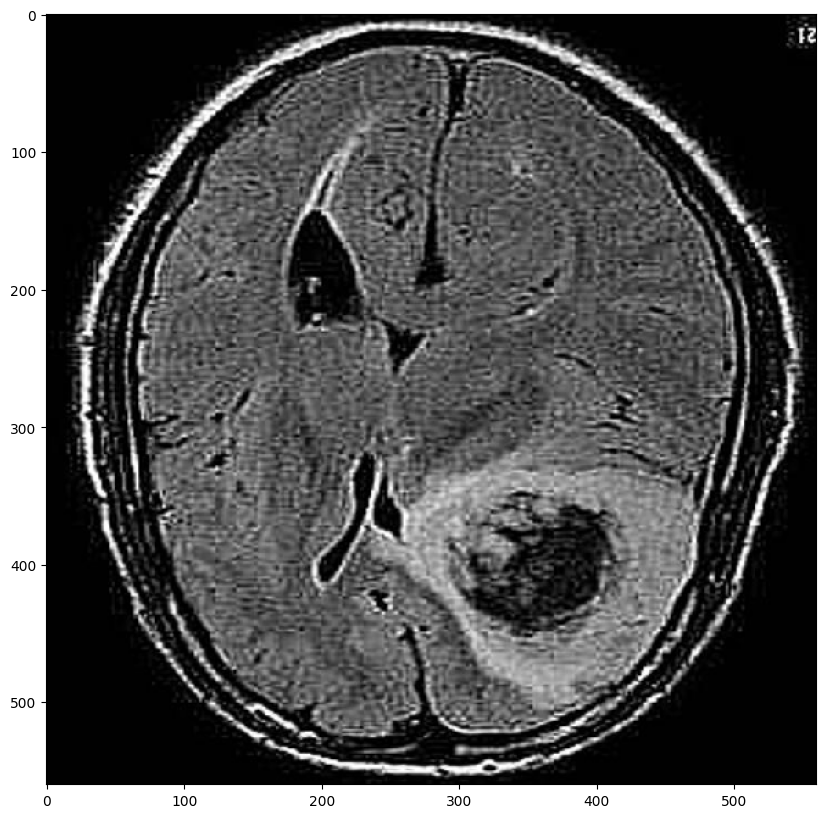

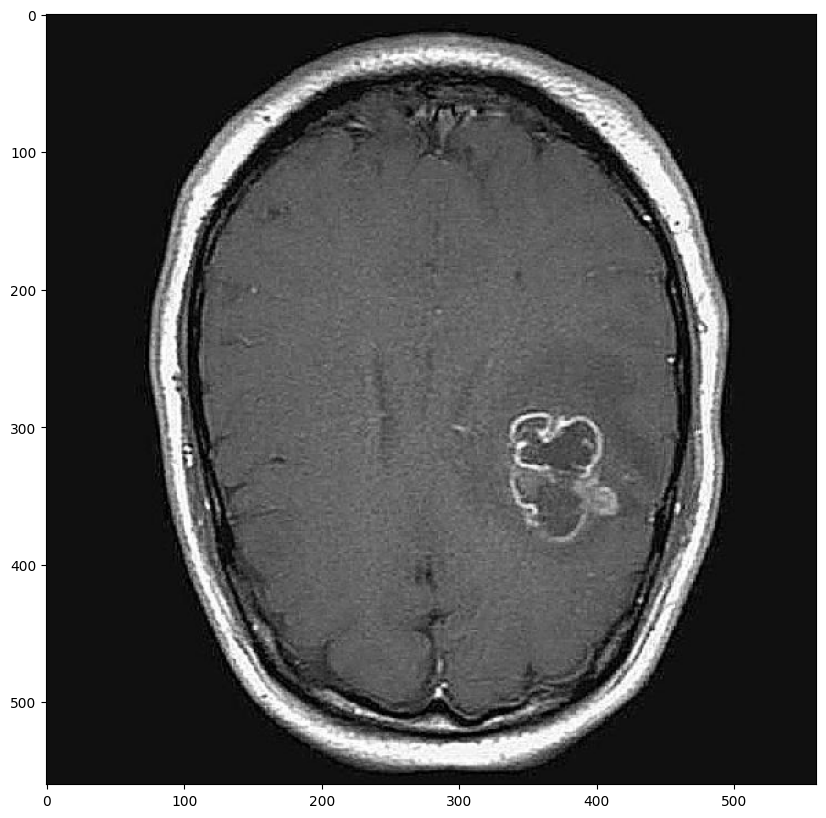

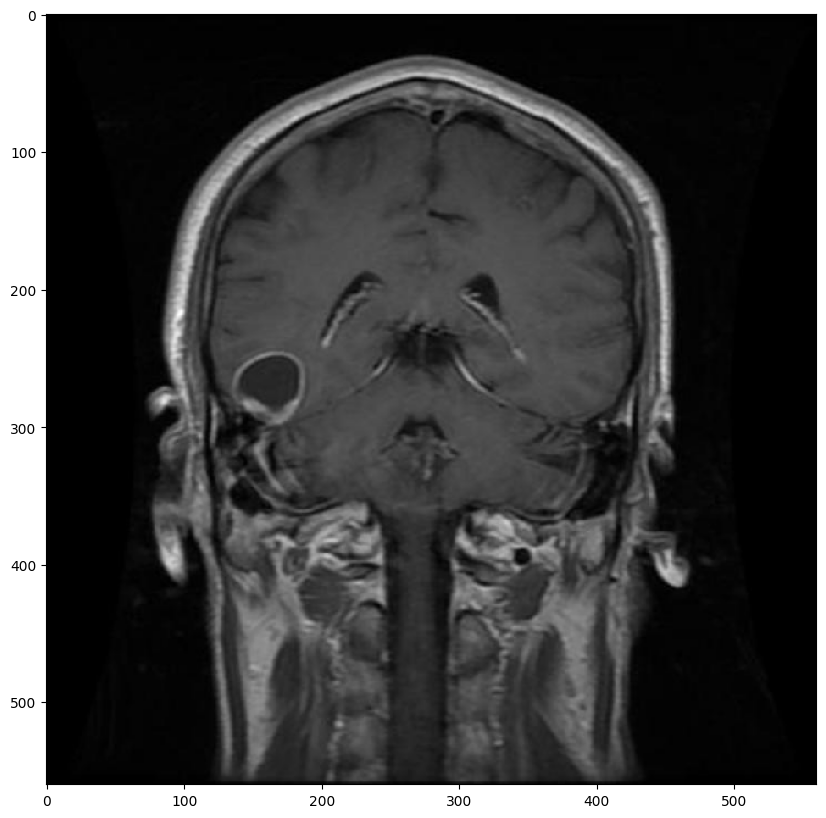

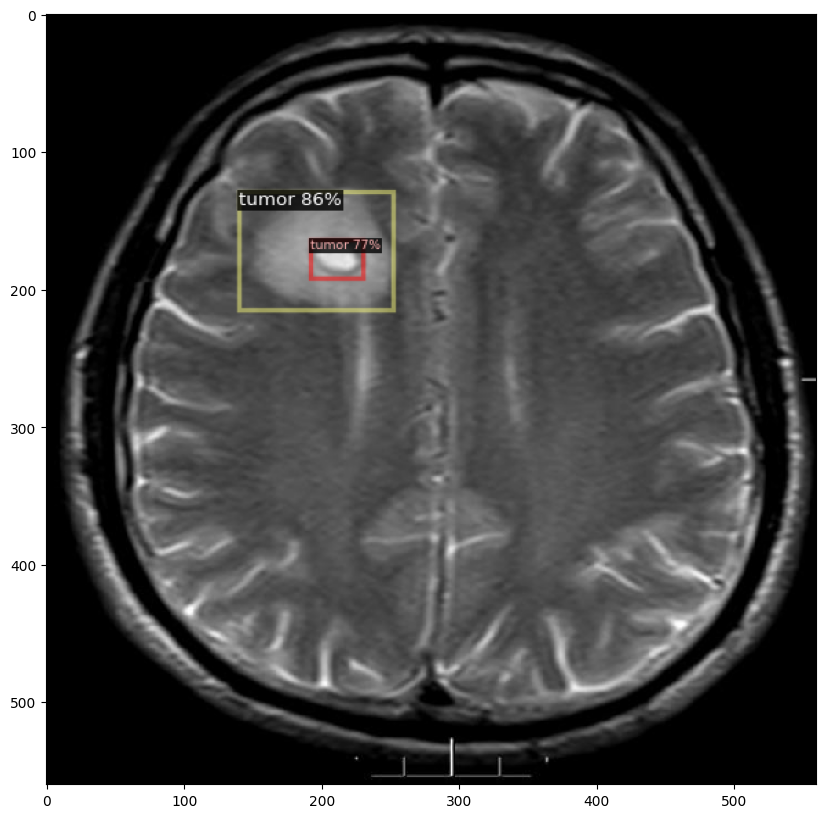

In [ ]:
for a in random.sample(test_dataset_dicts,4):
  img = cv2.imread(a['file_name'])
  ciktilar = tahmin(img)
  g = Visualizer(img[:,:,::-1],
                 metadata=microcontroller_metadata,
                 scale=0.8)
  g = g.draw_instance_predictions(ciktilar["instances"].to("cpu"))
  plt.figure(figsize=(20,10))
  plt.imshow(cv2.cvtColor(g.get_image()[:,:,::-1], cv2.COLOR_BGR2RGB))
  plt.show()

###Tespit

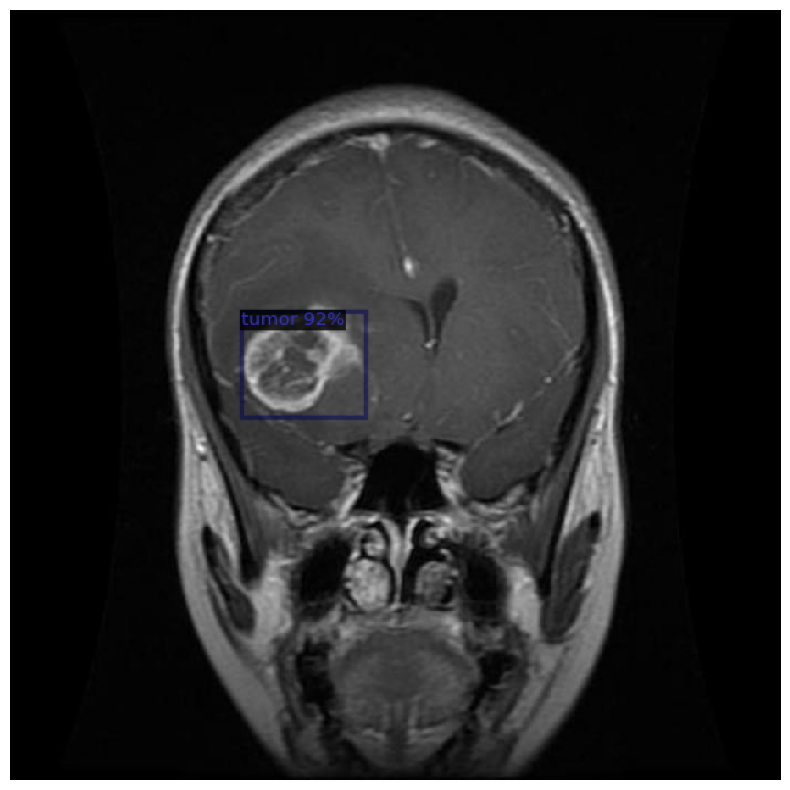

In [ ]:
img = cv2.imread('Cancer (310).jpg')
ciktilar = tahmin(img)
g = Visualizer(img[:,:,::-1],
                 metadata=microcontroller_metadata,
                 scale=0.8)
g = g.draw_instance_predictions(ciktilar["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(g.get_image()[:,:,::-1], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()